# Product categorization

Objectif: Regrouper des items en différentes catégories plus générales en se basant sur une analyse sémantique du contenu de la description.
Contrainte: La description ne fait que quelques mots, c'est une entête.
Un exemple d'application pourrait être un site d'échange/ventes entre particulier où le produit est décrit en qq mots par l'utilisateur. Ou alors des messages dont on n'aurait que le sujet, pas le corps du texte.

Le problème s'identifie à du topic modeling mais avec un texte (document) très court

- Exploration / formatage
- Approche Bag of words suivie d'un k-Means
- A pproche Latent Dirichlet Allocation
- Approches hybrides: guided LDA? Autres?

In [1]:
# modules
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import nltk

note: le fichier original a été lu en 'latin1' puis ré-encodé en 'utf-8' pour plus de simplicité

In [35]:
# Data
data = pd.read_csv('data/data.csv',index_col=0)
data.head(10)

,product_name
0,Appareil à chichis
1,dvd raiponce
2,Raquette de squash artengo sr 840
3,lunette astronomique
4,appareil à chaussons
5,Appareil à fondue au chocolat
6,Petit futé Italie du Nord 2013 - guide
7,Coupe ananas
8,8 flûtes à champagne
9,VTT


In [51]:
data.shape

(5206, 1)

# 1. Exploration

Commençons par regarder le vocabulaire composant tous ces noms de produits

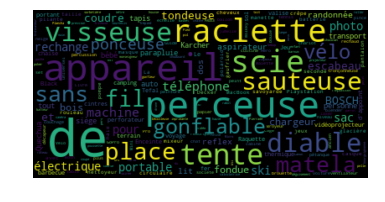

In [5]:
#
from wordcloud import WordCloud

texte = ' '.join(data['product_name'])
# collocations=False pour éviter qu'il ne considère des paires de mots fréquentes
wordcloud = WordCloud(collocations=False).generate(texte)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

En premier aperçu on peut générer un nuage de mots pour mettre en évidence les mots les plus fréquents.

Un certain nombre de mots comme "de" seront à considérer comme des mots vides (stopwords). De plus, il est préférable de regrouper ensemble tous les mots partageant la même racine (expl: 'perceuse' et 'perceuses')

In [7]:
#
from nltk.corpus import stopwords
french_stopwords = set(stopwords.words('french'))
tokenizer = nltk.RegexpTokenizer(r'\b\w\w+\b')
stemmer = stemmer = nltk.stem.SnowballStemmer("french")

racine_kw = {}
count_kw = {}

for word in tokenizer.tokenize(texte):
    word = word.lower()
    if word in french_stopwords: continue
    racine = stemmer.stem(word)
    if racine in racine_kw:
        racine_kw[racine].add(word)
        count_kw[racine] += 1
    else:
        racine_kw[racine] = {word}
        count_kw[racine] = 1

rac = []
occ = []
gen = []
for r in racine_kw.keys():
    rac.extend([r])
    occ.extend([count_kw[r]])
    gen.extend([min(racine_kw[r])])
    df = pd.DataFrame({'racine':rac, 'générique':gen, 'occurence':occ})

df.head(10)

,générique,occurence,racine
0,appareil,449,appareil
1,chichis,4,chich
2,dvd,6,dvd
3,raiponce,1,raiponc
4,raquette,35,raquet
5,squash,4,squash
6,artengo,2,artengo
7,sr,3,sr
8,840,2,840
9,lunette,2,lunet


la méthode de 'stemming' pour le français de nltk n'est pas entièrement satisfaisante mais elle fera l'affaire pour le moment.

sous 'générique' on répertorie pour chaque 'racine', un des mots correspondant à cette racine (on choisit le plus court), c'est ce mot générique qui servira à nommer le groupe (c'est plus clair d'afficher 'raquette' plutôt que 'raquet'!)

In [11]:
# summary
print('Nombre de mots différents répertoriés: ', df.shape[0])
print('Nombre total de mots: ', sum(df['occurence']))

Nombre de mots différents répertoriés:  1635
Nombre total de mots:  11718


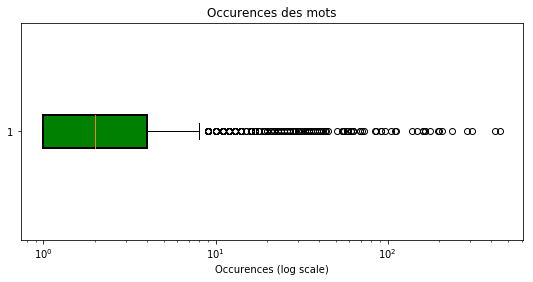

In [34]:
# Boxplot
fig, ax = plt.subplots(figsize=(9, 4))

bp = ax.boxplot(df['occurence'], vert=False, patch_artist=True)
plt.xscale("log")
for box in bp['boxes']:
    # change fill color
    box.set( facecolor='green', linewidth=2)
ax.set_xlabel('Occurences (log scale)')
ax.set_title('Occurences des mots')
plt.show()

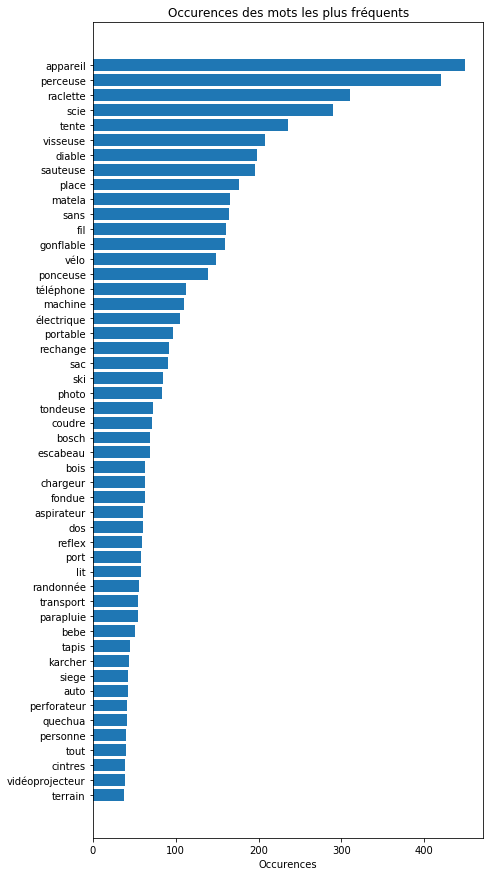

In [9]:
# histogramme
fig, ax = plt.subplots(figsize=(7, 15))

tmp = df.sort_values(by=['occurence'], ascending=False)
tmp = tmp[:50]
xx = tmp['générique'].values
yy = tmp['occurence'].values

y_pos = np.arange(len(xx))

ax.barh(y_pos, yy)
ax.set_yticks(y_pos)
ax.set_yticklabels(xx)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Occurences')
ax.set_title('Occurences des mots les plus fréquents')

plt.show()

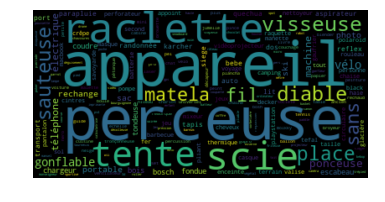

In [36]:
# nouveau nuages de mots
# on crée une liste avec tous les mots génériques 
# répétés autant de fois qu'ils ont été dénombrés
test = ''
for i in df.index:
    tmp = ' '.join([df.iloc[i]['générique']]*df.iloc[i]['occurence'])
    test = ' '.join([test,tmp])
# collocations=False pour éviter qu'il ne considère des paires de mots fréquentes
wordcloud = WordCloud(collocations=False).generate(test)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# 2. Clustering

In [37]:
def stemming_corpus(corpus):
    ## stemming corpus
    # le stemmer doit être appliqué sur des tokens
    # tous les mots des documents sont processés 
    # mais je conserve au final le format de corpus
    from nltk.corpus import stopwords
    french_stopwords = set(stopwords.words('french'))
    tokenizer = nltk.RegexpTokenizer(r'\b\w\w+\b')
    stemmer = stemmer = nltk.stem.SnowballStemmer("french")
    stemmed_corpus = []
    for doc in corpus:
        s = ' '
        stemmed_corpus.extend(
            [s.join([stemmer.stem(w) for w in tokenizer.tokenize(doc) 
                     if w.lower() not in french_stopwords])]
        )
    return(stemmed_corpus)

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(min_df=5, max_df=0.95, # ignore termes présents ds plus 95% doc
                                                     # et termes présents dans moins de 5 doc
                             ngram_range=(1, 2)) # si je veux considérer ts les unigrammes et tous les bigrammes
count_vect = TfidfVectorizer(min_df=5, max_df=0.95, 
                             ngram_range=(1, 2)) 

corpus = stemming_corpus(list(data['product_name']))
tfidf_vect.fit(corpus)
count_vect.fit(corpus)
vocabulaire = tfidf_vect.vocabulary_
print('Vocabulary size: {}'.format(len(tfidf_vect.vocabulary_)))

Vocabulary size: 592


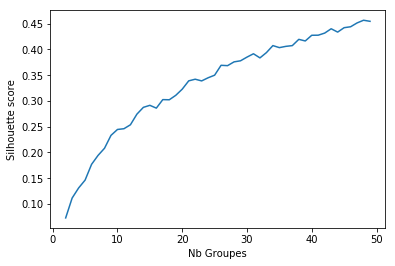

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

X_train = tfidf_vect.transform(corpus)
Xbis = count_vect.transform(corpus)
silh = []
for k in range(2,50):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train)
    silh.append(silhouette_score(Xbis, kmeans.labels_))

plt.plot(np.arange(2,50),silh)
plt.xlabel('Nb Groupes')
plt.ylabel('Silhouette score')
plt.show()

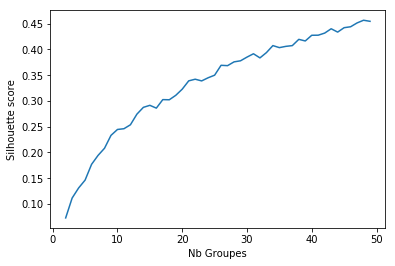

In [48]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

X_train = tfidf_vect.transform(corpus)
#Xbis = count_vect.transform(corpus)
silh = []
for k in range(2,50):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_train)
    silh.append(silhouette_score(X_train, kmeans.labels_))

plt.plot(np.arange(2,50),silh)
plt.xlabel('Nb Groupes')
plt.ylabel('Silhouette score')
plt.show()

Le score silhouette augmente avec le nb de cluster; semble augmenter un peu moins vite après 10 clusters. 

(on notera que le calcul n'est pas affecté par le choix de la matrice soit dénombrement soit tf-idf)

pour rappel, il y a 5206 produits

In [52]:
# choix clustering à 10 clusters
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_train)

In [67]:
data['labels'] = kmeans.labels_
data.head()

,product_name,labels
0,Appareil à chichis,5
1,dvd raiponce,8
2,Raquette de squash artengo sr 840,8
3,lunette astronomique,8
4,appareil à chaussons,5


In [66]:
print(df.shape)
print(len(kmeans.labels_))

(1635, 3)
5206


<function matplotlib.pyplot.show>

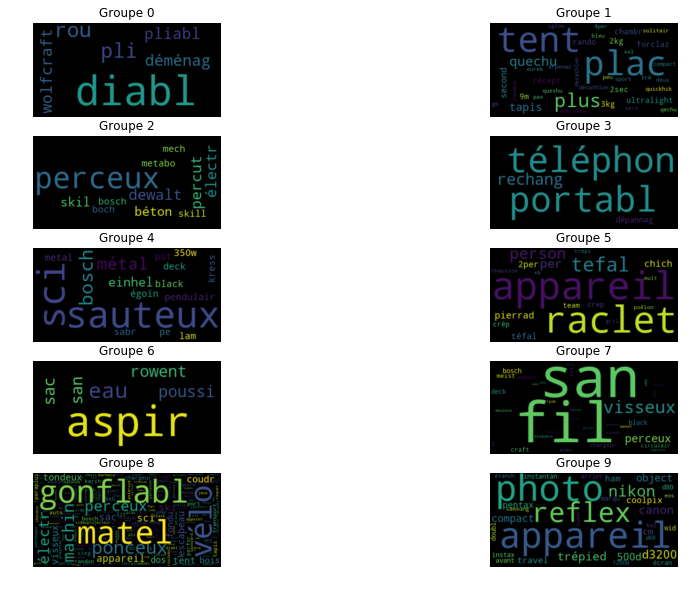

In [77]:
fig = plt.figure(figsize=(15,10))
for i in range(10):
    df_tmp=data[data['labels']==i]
    corpus_tmp=stemming_corpus(df_tmp['product_name'])
    corpus_tmp=' '.join(corpus_tmp)
    plt.subplot(5,2,i+1)
    # collocations=False pour éviter qu'il ne considère des paires de mots fréquentes
    wordcloud = WordCloud(collocations=False).generate(corpus_tmp)
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Groupe {}'.format(i))
    plt.axis("off")
plt.show

In [73]:
data[data['labels']==0].head()

,product_name,labels
141,Diable,0
245,Diable,0
352,Diable,0
361,Diable,0
411,Diable pliant,0


In [ ]:
data[data['labels']==0].head()